# Chapter 10. Big Entropy and the Generalized Linear Model

In [ ]:
!pip install -q numpyro arviz

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, tree_map, vmap

import numpyro
import numpyro.distributions as dist

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

### Code 10.1

In [2]:
p = {}
p["A"] = jnp.array([0, 0, 10, 0, 0])
p["B"] = jnp.array([0, 1, 8, 1, 0])
p["C"] = jnp.array([0, 2, 6, 2, 0])
p["D"] = jnp.array([1, 2, 4, 2, 1])
p["E"] = jnp.array([2, 2, 2, 2, 2])

### Code 10.2

In [3]:
p_norm = tree_map(lambda q: q / jnp.sum(q), p)

### Code 10.3

In [4]:
H = tree_map(lambda q: -jnp.sum(jnp.where(q == 0, 0, q * jnp.log(q))), p_norm)
H

{'A': DeviceArray(-0., dtype=float32),
 'B': DeviceArray(0.6390318, dtype=float32),
 'C': DeviceArray(0.95027053, dtype=float32),
 'D': DeviceArray(1.4708084, dtype=float32),
 'E': DeviceArray(1.609438, dtype=float32)}

### Code 10.4

In [5]:
ways = jnp.array([1, 90, 1260, 37800, 113400])
logwayspp = jnp.log(ways) / 10

### Code 10.5

In [6]:
# build list of the candidate distributions
p = {}
p[1] = jnp.array([1 / 4, 1 / 4, 1 / 4, 1 / 4])
p[2] = jnp.array([2 / 6, 1 / 6, 1 / 6, 2 / 6])
p[3] = jnp.array([1 / 6, 2 / 6, 2 / 6, 1 / 6])
p[4] = jnp.array([1 / 8, 4 / 8, 2 / 8, 1 / 8])

# compute expected value of each
tree_map(lambda p: jnp.sum(p * jnp.array([0, 1, 1, 2])), p)

{1: DeviceArray(1., dtype=float32),
 2: DeviceArray(1., dtype=float32),
 3: DeviceArray(1., dtype=float32),
 4: DeviceArray(1., dtype=float32)}

### Code 10.6

In [7]:
# compute entropy of each distribution
tree_map(lambda p: -jnp.sum(p * jnp.log(p)), p)

{1: DeviceArray(1.3862944, dtype=float32),
 2: DeviceArray(1.3296614, dtype=float32),
 3: DeviceArray(1.3296614, dtype=float32),
 4: DeviceArray(1.2130076, dtype=float32)}

### Code 10.7

In [8]:
p = 0.7
A = jnp.array([(1 - p) ** 2, p * (1 - p), (1 - p) * p, p**2])
A

DeviceArray([0.09, 0.21, 0.21, 0.49], dtype=float32)

### Code 10.8

In [9]:
-jnp.sum(A * jnp.log(A))

DeviceArray(1.2217286, dtype=float32)

### Code 10.9

In [10]:
def sim_p(i, G=1.4):
    x123 = dist.Uniform().sample(random.PRNGKey(i), (3,))
    x4 = (G * jnp.sum(x123, keepdims=True) - x123[1] - x123[2]) / (2 - G)
    z = jnp.sum(jnp.concatenate([x123, x4]))
    p = jnp.concatenate([x123, x4]) / z
    return {"H": -jnp.sum(p * jnp.log(p)), "p": p}

### Code 10.10

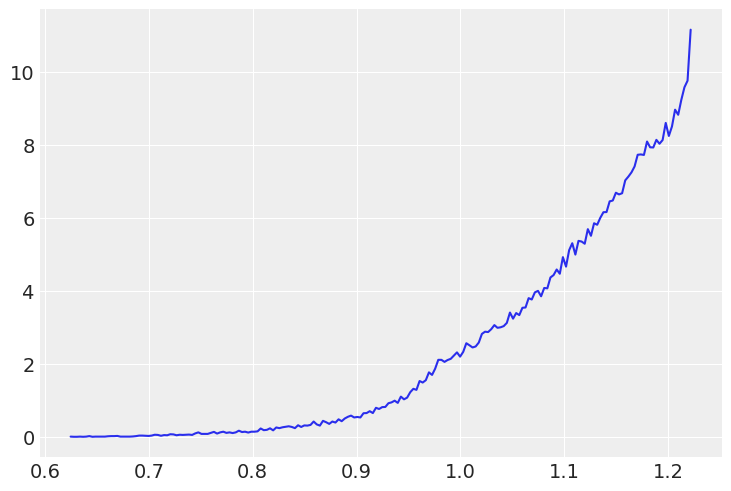

In [11]:
H = vmap(lambda i: sim_p(i, G=1.4))(jnp.arange(int(1e5)))
az.plot_kde(H["H"], bw=0.25)
plt.show()

### Code 10.11

In [12]:
entropies = H["H"]
distributions = H["p"]

### Code 10.12

In [13]:
jnp.max(entropies)

DeviceArray(1.2217282, dtype=float32)

### Code 10.13

In [14]:
distributions[jnp.argmax(entropies)]

DeviceArray([0.09018064, 0.20994425, 0.20969447, 0.49018064], dtype=float32)